### Import Packages and Dependencies

In [1]:
import os
import sys
from pathlib import Path

os.chdir(Path(os.getcwd()).parents[0])
sys.path.append(os.getcwd())

from pytorch_lightning import LightningDataModule
from matplotlib.colors import LinearSegmentedColormap
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy as np
import ast
import fnmatch

/home/l727n/anaconda3/envs/xai-eval/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.data.vesselmnist3d_datamodule import VesselMNSIT3DDataModule
from src.data.organmnist3d_datamodule import OrganMNSIT3DDataModule

print(sorted(glob.glob("data/attribution_maps/Voxel/*"), key=os.path.getmtime))

file = sorted(glob.glob("data/attribution_maps/Voxel/*"), key=os.path.getmtime)[-1] # selects always the newsest
array = np.load(file)
data = [array['arr_0'],array['arr_1'],array['arr_2']]


if fnmatch.fnmatch(file, '*Organ*'):
    datamodule = OrganMNSIT3DDataModule(data_dir = "data/datasets/", batch_size = 20)
    classes = ["liver","kidney-right","kidney-left","femur-right","femur-left","bladder","heart","lung-right","lung-left","spleen","pancreas"]
    
if fnmatch.fnmatch(file, '*Vessel*'):
    datamodule = VesselMNSIT3DDataModule(data_dir = "data/datasets/", batch_size = 20)
    classes = ["vessel", "aneurysm"]

dataloader = datamodule.dataloader()

with torch.no_grad():
    x_batch, y_batch = next(iter(dataloader))


['data/attribution_maps/Voxel/attr_OrganMNIST3D_dataset_14_methods_2023-04-18_16-38-04.npz', 'data/attribution_maps/Voxel/attr_VesselMNIST3D_dataset_14_methods_2023-04-18_16-43-27.npz']


In [15]:
methods = ["Occlusion","LIME (Mask)","Kernel SHAP (Mask)","Saliency","Input x Gradient", "Guided Backprob","GradCAM","ScoreCAM","GradCAM++", "IG", "EG", "Deeplift", "Deeplift SHAP", "LRP", "Raw Attention", "Rollout Attention", "LRP Attention"]
models = ["3DResNet18","3DEfficientNetb0","Simple3DFormer"]
n = 1
model = 2
img = x_batch[n].detach().numpy().transpose(1,2,3,0)

methods.append("Orignal Class: " + str(classes[int(y_batch[n])]).title())

Text(0.5, 1.0, 'Class: spleen\nXAI: LRP Attention\nModel: Simple3DFormer')

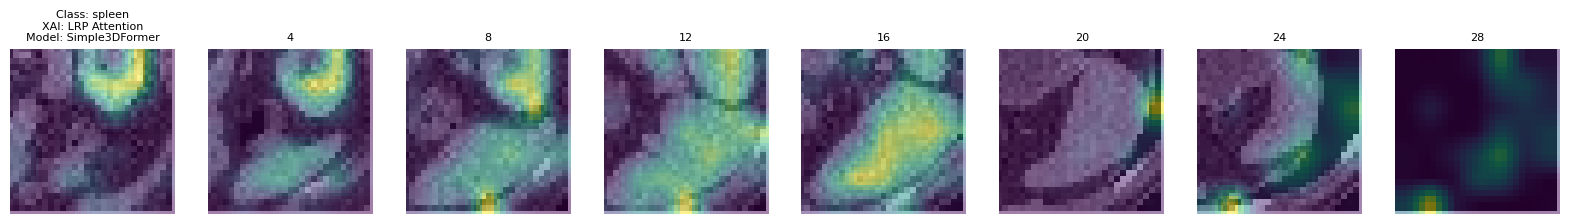

In [143]:
fig, axes = plt.subplots(1, 8, figsize=(20, 7), sharey=True, sharex = True)


xai = 16

for i in range(8):
    idx = np.min([(i*4), 27])
    mask = np.abs(data[model][n,xai,:,:,:,idx]) # obs , XAI, c, w, h, z
    axes[i].imshow(img[:,:,idx,:],cmap='gray')
    sns.heatmap(ax =  axes[i], data = mask[0,:,:],cbar=False, cmap="viridis", alpha=0.5)
    axes[i].axis('off')
    axes[i].axes.set_title(str((i*4)),fontsize=8)

axes[0].axes.set_title("Class: " + str(classes[int(y_batch[n])]+ "\nXAI: " + methods[xai] + "\nModel: " + models[model]),fontsize=8)

In [17]:
import plotly.graph_objects as go
import numpy as np
from plotly.subplots import make_subplots
from matplotlib.colors import LinearSegmentedColormap

cmap = [[0, 'white'], [0.5, 'red'], [1, 'red']]
titles = methods if model == 2 else methods[0:14] + [methods[17]]

def NormalizeData(data):
    return (data - np.min(data)) / ((np.max(data) - np.min(data)) + 0.00000000001)

X, Y, Z = np.mgrid[0:28:28j, 0:28:28j, 0:28:28j]
colorbar = dict(tickfont=dict(family="Helvetica", size=18), outlinewidth  = 0, thickness = 20, len = 0.8)

fig = make_subplots(
    rows=3,
    cols=7,
    specs=[
        [
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
        ],
        [
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
        ],
        [
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
            None,
            None,
            None,
        ]
    ] if model == 2 else
    [
        [
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
        ],
        [
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
            {"type": "scene"},
        ],
        [
            {"type": "scene"},
            None,
            None,
            None,
            None,
            None,
            None,
        ]
    ],
    subplot_titles=titles,
    vertical_spacing=0.05,
)

for i in range(7):
    fig.add_trace(
        go.Volume(
            x=X.flatten(),
            y=Y.flatten(),
            z=Z.flatten(),
            value=NormalizeData(np.abs(data[model][n, i, :, :, :, :]).flatten()),
            isomin=0.1,
            isomax=1.0,
            opacity=0.1,  # needs to be small to see through all surfaces
            surface_count=21,  # needs to be a large number for good volume rendering
            colorscale="viridis",
            colorbar= colorbar
        ),
        row=1,
        col=i + 1,
    )

for i in range(7):
    fig.add_trace(
        go.Volume(
            x=X.flatten(),
            y=Y.flatten(),
            z=Z.flatten(),
            value=NormalizeData(np.abs(data[model][n, i + 7, :, :, :, :]).flatten()),
            isomin=0.1,
            isomax=1.0,
            opacity=0.1,  # needs to be small to see through all surfaces
            surface_count=21,  # needs to be a large number for good volume rendering
            colorscale="viridis",
            colorbar= colorbar
        ),
        row=2,
        col=i + 1,
    )

if model == 2:
    for i in range(3):
        fig.add_trace(
            go.Volume(
                x=X.flatten(),
                y=Y.flatten(),
                z=Z.flatten(),
                value=NormalizeData(np.abs(data[model][n, i + 14, :, :, :, :]).flatten()),
                isomin=0.2,
                isomax=1.0,
                opacity=0.1,  # needs to be small to see through all surfaces
                surface_count=21,  # needs to be a large number for good volume rendering
                colorscale="viridis",
                showscale=False,
            ),
            row=3,
            col=i + 1,
        )

fig.add_trace(
    go.Volume(
        x=X.flatten(),
        y=Y.flatten(),
        z=Z.flatten(),
        value= NormalizeData(img[:,:,:,0].flatten()),
        isomin=0.02,
        isomax=1.0,
        opacity=0.95,  # needs to be small to see through all surfaces
        surface_count=21,  # needs to be a large number for good volume rendering
        showscale=False,
        colorscale = cmap
    ),
    row=3,
    col=4 if model == 2 else 1,
)

fig.update_scenes(
    xaxis_showticklabels=False,
    yaxis_showticklabels=False,
    zaxis_showticklabels=False,
    xaxis_title=" ",
    yaxis_title=" ",
    zaxis_title="",
)

fig.update_annotations(font=dict(family="Helvetica", size=22))

fig.update_layout(
    title=dict(
        text="<b>3D Attribution and Attention for " + models[model] + " Model</b>",
        font=dict(family="Helvetica", size=28), x = 0.03
    ),
    height=1200,
    width=2500,
    font=dict(
        family="Helvetica",
        color="#000000",
    ),
)

fig.write_image("data/figures/3D_Importance.png", scale=2)
# fig.show()
